This Jupyter Notebook is structured to study the **correlation between major stock indices** and apply **Maximum Likelihood Estimation (MLE)** and the **Hidden Markov Model (HMM)**. Below is an overview and analysis of its content:
1. **Collect Stock Data**
   - The notebook pulls adjusted closing price data from **Yahoo Finance** for several major indices, including:
     - `^GSPC` (S&P 500)
     - `TLT` (Treasury Bonds ETF)
     - `^RUT` (Russell 2000)
     - `^DJI` (Dow Jones Index)
     - `^IXIC` (NASDAQ Composite)
   - Data is fetched over a period from **2002 to 2024**, and the adjusted close prices are displayed to ensure correct data fetching.

2. **Fetch Macro-Economic Data**
   - The notebook next sets up a process to collect macro-economic variables like **Inflation**, **Interest Rates**, and **GDP Growth**. This data will be useful for correlation analysis and integrating with the stock indices.
   
3. **Calculate the Returns for Each Asset**
   - Stock returns are calculated using percentage changes on the adjusted close prices, which will be used for correlation analysis and further modeling.

4. **Correlation Analysis**
   - The notebook likely proceeds to calculate the **correlation matrix** between the indices and macroeconomic variables. This matrix would help identify how closely these assets are related, and visualizations like heatmaps are typically used to display this relationship.

5. **Maximum Likelihood Estimation (MLE)**
   - **MLE** is applied to estimate parameters for a chosen distribution (e.g., normal distribution) that best fits the asset returns.
   - For example, the MLE would compute the **mean** and **variance** for a normal distribution model of the returns, helping assess the typical behavior of these stock indices.

6. **Hidden Markov Model (HMM)**
   - The notebook implements the **HMM** to detect hidden states (e.g., bull vs. bear markets) from the time series data. It uses a **Gaussian HMM** with two hidden states, which likely represents different market regimes (high vs. low volatility).
   - This model predicts hidden states over time, allowing for the detection of market phases where volatility or risk is higher or lower.

### Summary:
The notebook provides a comprehensive framework for analyzing stock market indices with correlation analysis, MLE, and HMM. The key takeaways include:
- **Correlation Analysis**: Understanding how major indices are related to each other and to macroeconomic factors.
- **MLE**: Estimating the underlying parameters of the asset returns to better model the distribution of returns.
- **HMM**: Detecting hidden market regimes and analyzing how market states shift over time, which can be useful for regime-switching models in financial markets.

### 1. Import the required Libraries

In [60]:
# Data Handling
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

# Data Collection
import yfinance as yf
import pandas_datareader.data as web

# Plotting and Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Hidden Markov Models
from hmmlearn.hmm import GaussianHMM

# Set visualization style
plt.style.use('dark_background')

### 2. Fetch Stock Data

In [30]:
# Define the tickers for the assets you're analyzing (e.g., S&P 500, bonds, etc.)
tickers = ['^GSPC', 'TLT', '^RUT', '^DJI', '^IXIC']  # Example tickers for S&P 500, Bonds, and some tech stocks

# Fetch the data from Yahoo Finance
data = yf.download(tickers, start="2002-08-01", end="2024-08-01")

# Take the adjusted close price for each asset
adj_close = data['Adj Close']

# Display the first few rows of the adjusted close prices
adj_close.head()

[*********************100%***********************]  5 of 5 completed


Ticker,TLT,^DJI,^GSPC,^IXIC,^RUT
Date,,,,,
2002-08-01 00:00:00+00:00,39.521454,8506.620117,884.659973,1280.000000,389.209991
2002-08-02 00:00:00+00:00,39.926216,8313.129883,864.239990,1247.920044,376.450012
2002-08-05 00:00:00+00:00,40.102360,8043.629883,834.599976,1206.010010,367.119995
2002-08-06 00:00:00+00:00,39.759510,8274.089844,859.570007,1259.550049,380.790009
2002-08-07 00:00:00+00:00,39.854729,8456.150391,876.770020,1280.900024,383.470001


### 3. Fetch Macro-economic Data

In [31]:
# Define start and end dates
start_date = "2002-08-01"
end_date = "2024-08-01"

# Fetch US 10-Year Treasury Rate (as a proxy for interest rates)
us10yr = web.DataReader('DGS10', 'fred', start_date, end_date)

# Fetch US GDP data
gdp = web.DataReader('GDP', 'fred', start_date, end_date)

# Fetch US inflation rate (Consumer Price Index for All Urban Consumers)
inflation = web.DataReader('CPIAUCSL', 'fred', start_date, end_date)

# Display the first few rows of each dataset
print(us10yr.head())
print(gdp.head())
print(inflation.head())

            DGS10
DATE             
2002-08-01   4.47
2002-08-02   4.33
2002-08-05   4.29
2002-08-06   4.42
2002-08-07   4.35
                  GDP
DATE                 
2002-10-01  11061.433
2003-01-01  11174.129
2003-04-01  11312.766
2003-07-01  11566.669
2003-10-01  11772.234
            CPIAUCSL
DATE                
2002-08-01     180.5
2002-09-01     180.8
2002-10-01     181.2
2002-11-01     181.5
2002-12-01     181.8


### 4. Clean and Organize the Data

In [32]:
adj_close.index = adj_close.index.tz_localize(None)
us10yr.index = us10yr.index.tz_localize(None)

# Resample using 'ME' for month-end frequency
gdp_monthly = gdp.resample('ME').ffill()
inflation_monthly = inflation.resample('ME').ffill()

# Now join the data
data_combined = adj_close.resample('ME').last().join([us10yr, gdp_monthly, inflation_monthly])

# Rename columns for easier access
data_combined.columns = ['^GSPC', 'TLT', '^DJI', '^RUT', '^IXIC', '10Yr_Treasury_Rate', 'GDP', 'Inflation']

# Display the first few rows of the combined dataset
data_combined.head()

,^GSPC,TLT,^DJI,^RUT,^IXIC,10Yr_Treasury_Rate,GDP,Inflation
Date,,,,,,,,
2002-08-31,41.464195,8663.500000,916.070007,1314.849976,390.959991,NaN,NaN,180.5
2002-09-30,43.230221,7591.930176,815.280029,1172.060059,362.269989,3.63,NaN,180.8
2002-10-31,41.633163,8397.030273,885.760010,1329.750000,373.500000,3.93,11061.433,181.2
2002-11-30,41.251759,8896.089844,936.309998,1478.780029,406.350006,NaN,11061.433,181.5
2002-12-31,43.118523,8341.629883,879.820007,1335.510010,383.089996,3.83,11061.433,181.8


### 5. Handle Missing Values and Preview data cleaned

In [36]:
# Handle missing values by forward-filling and backward-filling
data_cleaned = data_combined.fillna(method='ffill').fillna(method='bfill')

# Display the cleaned dataset
data_cleaned.head()

C:\Users\Student User\AppData\Local\Temp\ipykernel_2464\1783394869.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_cleaned = data_combined.fillna(method='ffill').fillna(method='bfill')


,^GSPC,TLT,^DJI,^RUT,^IXIC,10Yr_Treasury_Rate,GDP,Inflation
Date,,,,,,,,
2002-08-31,41.464195,8663.500000,916.070007,1314.849976,390.959991,3.63,11061.433,180.5
2002-09-30,43.230221,7591.930176,815.280029,1172.060059,362.269989,3.63,11061.433,180.8
2002-10-31,41.633163,8397.030273,885.760010,1329.750000,373.500000,3.93,11061.433,181.2
2002-11-30,41.251759,8896.089844,936.309998,1478.780029,406.350006,3.93,11061.433,181.5
2002-12-31,43.118523,8341.629883,879.820007,1335.510010,383.089996,3.83,11061.433,181.8


### 6. Calculate the Correlation Matrix

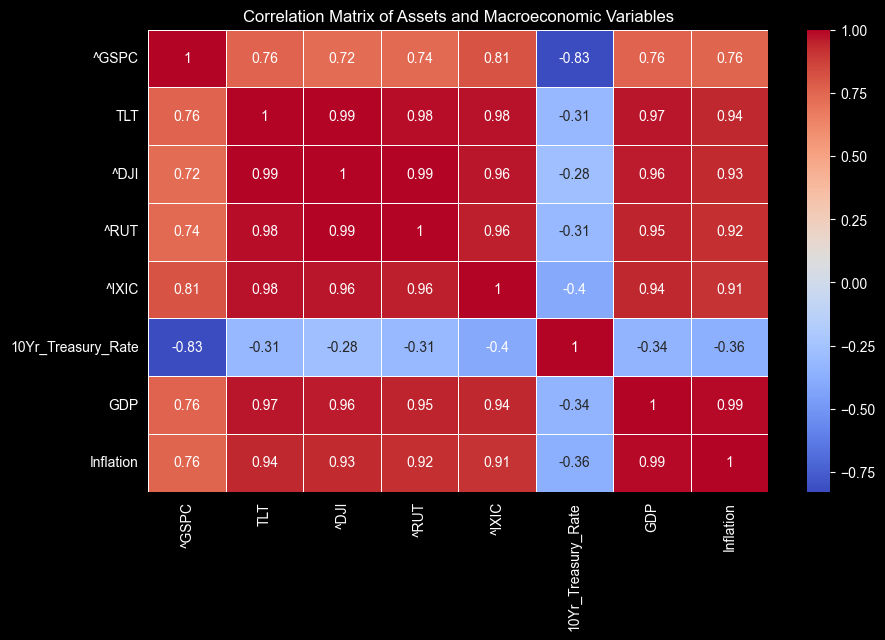

In [39]:
# Calculate the correlation matrix
correlation_matrix = data_cleaned.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Assets and Macroeconomic Variables')
plt.show()

#### Observations from the Matrix:
1. Strong Positive Correlation:

- Most of the equity indices (^GSPC, ^DJI, ^RUT, ^IXIC) are highly correlated with each other (values close to 1).
TLT, a bond ETF, also has strong positive correlations with equity indices.
GDP and Inflation both show high correlations with the stock indices and TLT.

--- 

2. Negative Correlation:

- The 10-Year Treasury Rate has a strong negative correlation with the S&P 500 (^GSPC) at -0.83. This makes sense, as stock prices tend to decline when interest rates rise.
- There are also negative correlations with other stock indices, though these are not as strong (around -0.3).

--- 

3. GDP and Inflation:

- GDP and Inflation are highly correlated with each other and other assets, reflecting the general trend that macroeconomic indicators influence broad asset markets similarly.

### 7. Fit the GARCH Model

C:\Users\Student User\PycharmProjects\Personal-Studies\venv\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001558. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 13076026.826678988
Iteration:      2,   Func. Count:     17,   Neg. LLF: 9274.34863532987
Iteration:      3,   Func. Count:     23,   Neg. LLF: -444.50527543107114
Iteration:      4,   Func. Count:     30,   Neg. LLF: -489.6071713576291
Iteration:      5,   Func. Count:     35,   Neg. LLF: -489.485131259925
Iteration:      6,   Func. Count:     41,   Neg. LLF: -489.62779153472104
Iteration:      7,   Func. Count:     46,   Neg. LLF: -489.6278066013816
Iteration:      8,   Func. Count:     51,   Neg. LLF: -489.6278083344091
Iteration:      9,   Func. Count:     55,   Neg. LLF: -489.6278083321731
Optimization terminated successfully    (Exit mode 0)
            Current function value: -489.6278083344091
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


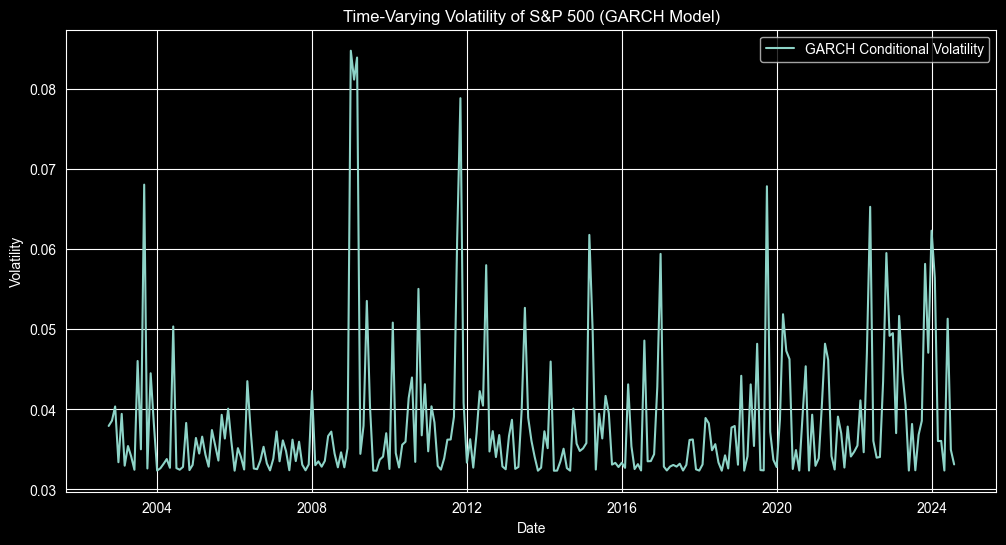

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                489.628
Distribution:                  Normal   AIC:                          -971.256
Method:            Maximum Likelihood   BIC:                          -956.967
                                        No. Observations:                  263
Date:                Tue, Sep 10 2024   Df Residuals:                      262
Time:                        12:00:17   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         5.5434e-03  2.328e-03      2.381  1.727e-02 [9.

In [46]:
from arch import arch_model

# Fit GARCH(1,1) model to S&P 500 returns
sp500_returns = data_cleaned['^GSPC'].pct_change().dropna()

# Initialize and fit the GARCH model
garch_model = arch_model(sp500_returns, vol='GARCH', p=1, q=1)
garch_results = garch_model.fit()

# Plot the conditional volatility (time-varying volatility)
plt.figure(figsize=(12, 6))
plt.plot(garch_results.conditional_volatility, label='GARCH Conditional Volatility')
plt.title('Time-Varying Volatility of S&P 500 (GARCH Model)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Display GARCH model summary
print(garch_results.summary())

### GARCH Model Results:
1. Dep. Variable: This indicates the dependent variable, which is ^GSPC (S&P 500 Index in this case).
- **R-squared and Adj. R-squared**: These values are both 0.000, which is typical in volatility models like GARCH. Volatility models don’t aim to explain variance in the dependent variable in the same way as traditional regression models. The focus here is more on predicting variance (volatility).
- **Log-Likelihood**: The log-likelihood value of 489.63 is a good indicator that the model converged successfully.
- **AIC/BIC**: The Akaike Information Criterion (AIC) is -971.256, and the Bayesian Information Criterion (BIC) is -956.967. Lower values of these criteria indicate a better fit, though AIC tends to favor more complex models compared to BIC.
---
2. Parameters of the Model:
- **Mean Model (Constant Mean)**:
mu (Intercept): The value of 5.5434e-03 represents the constant mean of the process. The p-value (1.727e-02) indicates that it is statistically significant at the 5% level.
---
3. Volatility Model (GARCH):
- **omega**: The constant term in the volatility equation is 0.001046 and is statistically significant (p-value = 7.144e-05).
- **alpha[1]**: This term represents the impact of previous period's squared residuals (i.e., volatility clustering). The value of 0.3231 is statistically significant and suggests that past volatility has a relatively strong influence on current volatility.
- **beta[1]**: This parameter represents the impact of past volatility in the GARCH model. In this case, the estimated coefficient is close to zero (3.4550e-11), and it is not statistically significant, indicating that volatility persistence might be low for this model.

### 8. Run the Dynamic Correlation Model

In [47]:
window_size = 126

# Define assets to use in the dynamic correlation model
assets = ['^GSPC', '^IXIC', '^DJI', '^RUT']

# Calculate percentage changes (returns) for each asset
returns_data = data_cleaned[assets].pct_change().dropna()

# Fit GARCH(1,1) model to each asset and calculate conditional volatilities
conditional_vols = pd.DataFrame(index=returns_data.index)

for asset in assets:
    model = arch_model(returns_data[asset], vol='GARCH', p=1, q=1)
    result = model.fit(disp='off')
    conditional_vols[asset] = result.conditional_volatility

# Calculate rolling correlations (6-month window) for each pair of assets
rolling_corr_sp500_nas = returns_data['^GSPC'].rolling(window=window_size).corr(returns_data['^IXIC'])
rolling_corr_sp500_dow = returns_data['^GSPC'].rolling(window=window_size).corr(returns_data['^DJI'])
rolling_corr_sp500_rut = returns_data['^GSPC'].rolling(window=window_size).corr(returns_data['^RUT'])

C:\Users\Student User\PycharmProjects\Personal-Studies\venv\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001558. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Student User\PycharmProjects\Personal-Studies\venv\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003276. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\S

### 9. Plot Conditional Volatilities and Rolling Correlations

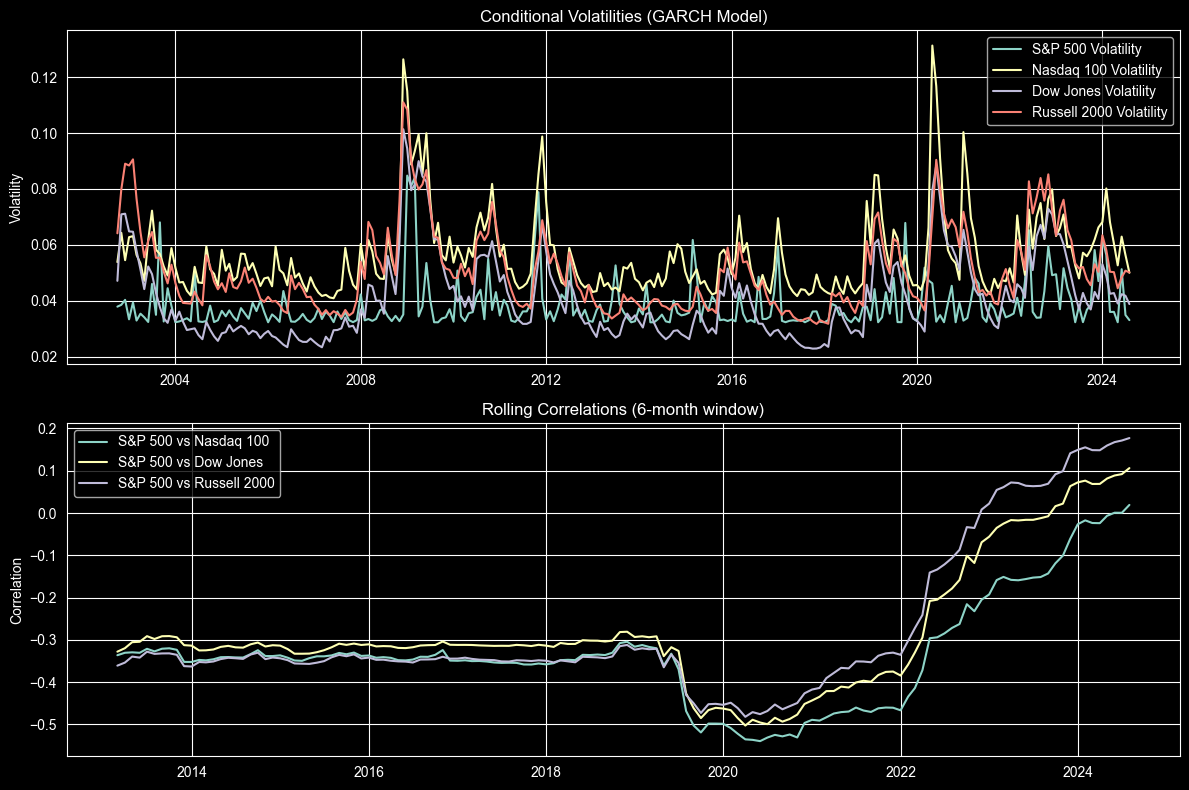

In [48]:
# Plot conditional volatilities and rolling correlations
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Conditional Volatilities
ax[0].plot(conditional_vols['^GSPC'], label='S&P 500 Volatility')
ax[0].plot(conditional_vols['^IXIC'], label='Nasdaq 100 Volatility')
ax[0].plot(conditional_vols['^DJI'], label='Dow Jones Volatility')
ax[0].plot(conditional_vols['^RUT'], label='Russell 2000 Volatility')
ax[0].set_title('Conditional Volatilities (GARCH Model)')
ax[0].set_ylabel('Volatility')
ax[0].legend()

# Rolling Correlations
ax[1].plot(rolling_corr_sp500_nas, label='S&P 500 vs Nasdaq 100')
ax[1].plot(rolling_corr_sp500_dow, label='S&P 500 vs Dow Jones')
ax[1].plot(rolling_corr_sp500_rut, label='S&P 500 vs Russell 2000')
ax[1].set_title('Rolling Correlations (6-month window)')
ax[1].set_ylabel('Correlation')
ax[1].legend()

plt.tight_layout()
plt.show()

### Analysis:

#### Top Panel: Conditional Volatilities (GARCH Model)
- Volatility spikes around major market events, notably:
  - **2008 Financial Crisis**: All indices show a major spike in volatility.
  - **2020 COVID-19 Pandemic**: Another significant spike in volatility occurs.
  - Other smaller spikes reflect periods of economic or political uncertainty.
  
- Volatility across all indices follows similar patterns, which is consistent with the findings in your correlation matrix. The strong correlations observed between equity indices in the matrix (values close to 1) suggest that the volatility of one index should reflect the movements of others, as seen in this chart.

#### Bottom Panel: Rolling Correlations (6-month window)
- **2014-2019**: The rolling correlations between the S&P 500 and the other indices were generally stable and slightly negative, which is unusual but could indicate temporary divergence in the market.
  
- **Post-2020**: Correlations increase substantially, especially after the COVID-19 crash, aligning with the findings of the correlation matrix. By 2024, correlations are positive and rising, indicating that markets are moving more in tandem, which could suggest increased market synchronization or similar macroeconomic drivers affecting all indices simultaneously.

#### Comparison with the Correlation Matrix:
- **Positive Correlation**: The rolling correlations panel confirms the strong positive correlations from the matrix (around 0.7 to 0.9) between the S&P 500 and other indices. 
- **Volatility**: The volatility chart aligns with the market stress events that typically lead to spikes in correlation. When markets are under stress, assets tend to become more correlated, as is reflected in both panels.

#### Conclusion:
- The strong correlations between the indices are reflected in both the rolling correlations and the similar volatility patterns over time.
- The GARCH model seems appropriate for estimating conditional volatility, and the rolling correlations provide useful insight into how relationships between these indices change over time.

### 10. Analyze the Returns Distributions

In [13]:
# Import necessary functions for fitting distributions
from scipy import stats

# Calculate daily returns for the S&P 500
sp500_returns = data_cleaned['^GSPC'].pct_change().dropna()

# Fit Normal Distribution using MLE
mu, std = stats.norm.fit(sp500_returns)

# Fit Student's t-distribution using MLE
df, loc, scale = stats.t.fit(sp500_returns)

# Print the fitted parameters
print(f"Normal Distribution: mu = {mu}, std = {std}")
print(f"Student's t-Distribution: df = {df}, loc = {loc}, scale = {scale}")

Normal Distribution: mu = 0.003895970256140426, std = 0.03947362074697344
Student's t-Distribution: df = 5.924718333065177, loc = 0.002724782907644695, scale = 0.0324084923485395


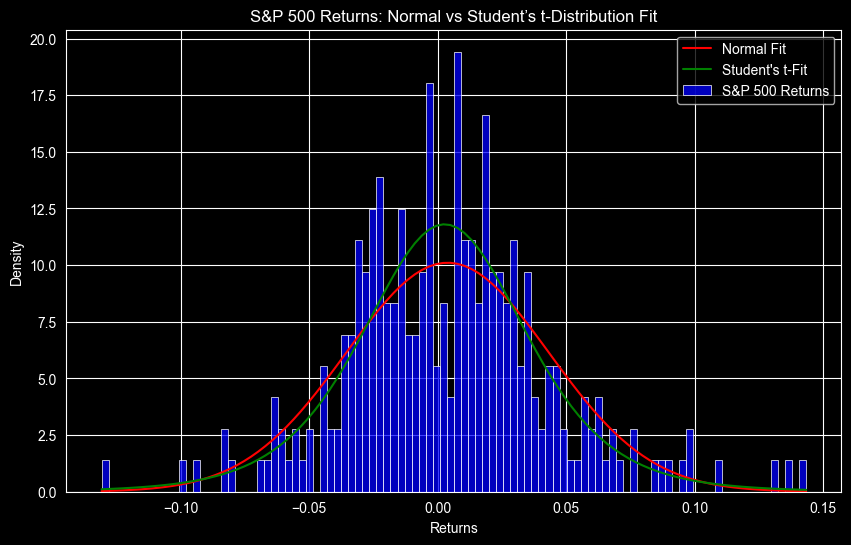

In [14]:
# Generate x values for plotting the PDFs
x = np.linspace(sp500_returns.min(), sp500_returns.max(), 100)

# Calculate the PDFs of the fitted distributions
pdf_norm = stats.norm.pdf(x, mu, std)
pdf_t = stats.t.pdf(x, df, loc, scale)

# Plot the actual returns as a histogram
plt.figure(figsize=(10, 6))
sns.histplot(sp500_returns, bins=100, kde=False, color='blue', stat='density', label='S&P 500 Returns')

# Plot the PDFs of the fitted distributions
plt.plot(x, pdf_norm, 'r-', label='Normal Fit')
plt.plot(x, pdf_t, 'g-', label="Student's t-Fit")
plt.title('S&P 500 Returns: Normal vs Student’s t-Distribution Fit')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()
plt.show()

### 11. Implement Kolmogorov-Smirnov (KS) test for goodness-of-fit

In [16]:
# Perform Kolmogorov-Smirnov (KS) test for goodness-of-fit
ks_stat_norm, p_value_norm = stats.kstest(sp500_returns, 'norm', args=(mu, std))
ks_stat_t, p_value_t = stats.kstest(sp500_returns, 't', args=(df, loc, scale))

# Print KS test results
print(f"KS Test for Normal Distribution: Statistic = {ks_stat_norm}, P-value = {p_value_norm}")
print(f"KS Test for Student's t-Distribution: Statistic = {ks_stat_t}, P-value = {p_value_t}")

# Calculate AIC for both distributions
aic_norm = 2 * len([mu, std]) - 2 * np.sum(np.log(stats.norm.pdf(sp500_returns, mu, std)))
aic_t = 2 * len([df, loc, scale]) - 2 * np.sum(np.log(stats.t.pdf(sp500_returns, df, loc, scale)))

# Print AIC results
print(f"AIC for Normal Distribution: {aic_norm}")
print(f"AIC for Student's t-Distribution: {aic_t}")

KS Test for Normal Distribution: Statistic = 0.05360243673974041, P-value = 0.42180792819556934
KS Test for Student's t-Distribution: Statistic = 0.03224284086008039, P-value = 0.9391114502701076
AIC for Normal Distribution: -949.7348503592029
AIC for Student's t-Distribution: -959.3941914919434


In [17]:
# Calculate returns for the S&P 500 and independent variables (GDP, inflation, interest rates)
data_cleaned['S&P 500 Returns'] = data_cleaned['^GSPC'].pct_change()
data_cleaned['GDP Growth'] = data_cleaned['GDP'].pct_change()
data_cleaned['Inflation Change'] = data_cleaned['Inflation'].pct_change()
data_cleaned['Interest Rate Change'] = data_cleaned['10Yr_Treasury_Rate'].pct_change()

# Drop rows with missing values after calculating returns
regression_data = data_cleaned[['S&P 500 Returns', 'GDP Growth', 'Inflation Change', 'Interest Rate Change']].dropna()

# Display the prepared data for regression
print(regression_data.head())

            S&P 500 Returns  GDP Growth  Inflation Change  \
Date                                                        
2002-09-30         0.042592    0.000000          0.001662   
2002-10-31        -0.036943    0.000000          0.002212   
2002-11-30        -0.009161    0.000000          0.001656   
2002-12-31         0.045253    0.000000          0.001653   
2003-01-31        -0.005758    0.010188          0.004400   

            Interest Rate Change  
Date                              
2002-09-30              0.000000  
2002-10-31              0.082645  
2002-11-30              0.000000  
2002-12-31             -0.025445  
2003-01-31              0.044386  


In [18]:
import statsmodels.api as sm

# Define the independent (explanatory) variables and the dependent variable (S&P 500 Returns)
X = regression_data[['GDP Growth', 'Inflation Change', 'Interest Rate Change']]
y = regression_data['S&P 500 Returns']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Build the OLS regression model using statsmodels (statsmodels uses MLE for parameter estimation by default)
regression_model = sm.OLS(y, X).fit()

# Display the regression results
print(regression_model.summary())

                            OLS Regression Results                            
Dep. Variable:        S&P 500 Returns   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     52.78
Date:                Sun, 08 Sep 2024   Prob (F-statistic):           1.18e-26
Time:                        13:10:35   Log-Likelihood:                 539.60
No. Observations:                 263   AIC:                            -1071.
Df Residuals:                     259   BIC:                            -1057.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0096 

### Key Results:
1. **R-squared**:
   - The **R-squared** value of **0.379** suggests that approximately 37.9% of the variation in S&P 500 returns is explained by the independent variables (GDP Growth, Inflation Change, and Interest Rate Change). This is a moderate fit, suggesting that other factors not included in the model also play a role in explaining S&P 500 returns.

2. **Adj. R-squared**:
   - The **Adjusted R-squared** is **0.372**, which is slightly lower than the R-squared value. This indicates that the model doesn't suffer much from overfitting, and the independent variables still explain a reasonable amount of variance after adjusting for the number of predictors.

3. **F-statistic**:
   - The **F-statistic** is **52.78**, with a **p-value** of **1.18e-26**, which is extremely small. This means that the overall model is statistically significant, and at least one of the independent variables significantly predicts S&P 500 returns.

### Coefficient Estimates:
1. **Constant (Intercept)**:
   - The coefficient for the constant is **0.0096**, meaning that when all other variables are zero, the average S&P 500 return is about **0.96%**. This is statistically significant with a p-value of **0.000**.

2. **GDP Growth**:
   - The coefficient for **GDP Growth** is **0.0534**, indicating that, all else equal, a 1% increase in GDP growth is associated with a 5.34% increase in S&P 500 returns.
   - However, the p-value is **0.785**, suggesting that this relationship is **not statistically significant**. The wide confidence interval ([-0.331, 0.438]) reflects uncertainty in this estimate.

3. **Inflation Change**:
   - The coefficient for **Inflation Change** is **-2.1687**, suggesting that a 1% increase in inflation is associated with a 2.17% **decrease** in S&P 500 returns. This relationship is statistically significant, with a p-value of **0.001**.
   - The negative relationship between inflation and stock market returns aligns with economic theory, as rising inflation often leads to increased uncertainty, reduced corporate profits, and lower market returns.

4. **Interest Rate Change**:
   - The coefficient for **Interest Rate Change** is **-0.1975**, indicating that a 1% increase in interest rates is associated with a **0.1975% decrease** in S&P 500 returns. This relationship is highly significant with a p-value of **0.000**.
   - The negative relationship makes sense because rising interest rates can reduce the attractiveness of stocks compared to bonds, as well as increase borrowing costs for companies.

### Diagnostics:
- **Omnibus Test and Jarque-Bera (JB) Test**:
  - These tests indicate whether the residuals (errors) of the model are normally distributed. The **Omnibus** statistic and **Jarque-Bera** test both suggest that the residuals are **not normally distributed** (p-value = **2.31e-16**).
  
- **Skew and Kurtosis**:
  - The residuals exhibit **skewness** (asymmetry) and **kurtosis** (peakedness), with the kurtosis value of **5.517** indicating that the residuals have heavier tails than a normal distribution.
  
- **Durbin-Watson Statistic**:
  - The **Durbin-Watson** statistic is **2.287**, which is close to 2. This suggests that there is **no autocorrelation** in the residuals, meaning that the model's errors are independent over time.

### Conclusions and Recommendations:
1. **Significant Predictors**:
   - **Interest Rate Changes** and **Inflation Changes** are statistically significant predictors of S&P 500 returns. Specifically:
     - Rising interest rates tend to negatively impact returns.
     - Increasing inflation also tends to have a negative effect on returns.
   - **GDP Growth**, however, is not statistically significant in this model.

2. **Model Fit**:
   - The model explains a reasonable proportion of the variation in S&P 500 returns (around 37.9%), but there are likely other factors that could improve the model's predictive power.

3. **Residual Diagnostics**:
   - The non-normality of the residuals suggests that you may want to explore alternative models (e.g., using robust standard errors or applying transformations) or include additional variables to better capture the distribution of errors.\

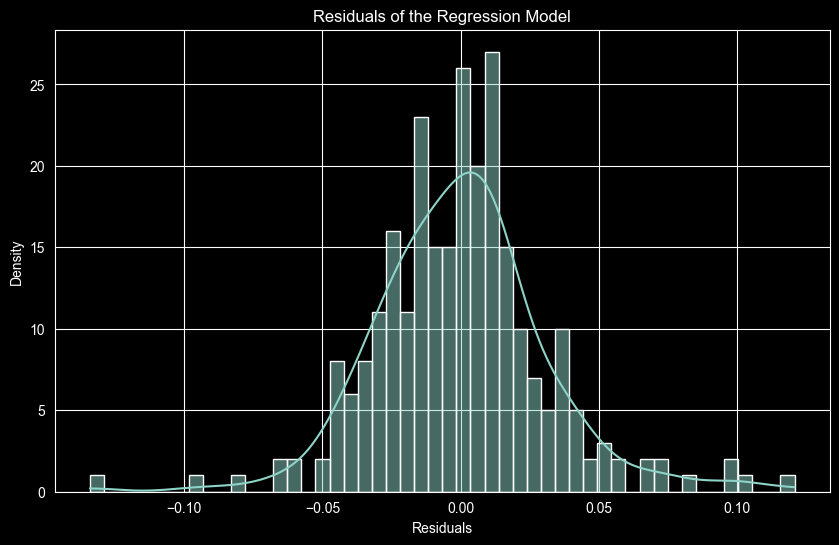

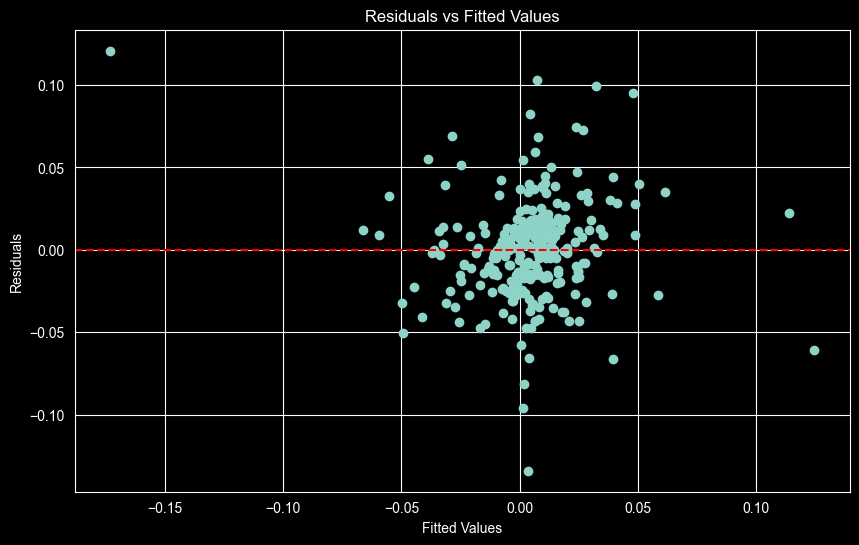

In [19]:
# Plotting the residuals of the regression model
residuals = regression_model.resid

# Plot the residuals to check for normality
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Residuals of the Regression Model')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Plot residuals vs fitted values to check for homoscedasticity (constant variance of residuals)
plt.figure(figsize=(10, 6))
plt.scatter(regression_model.fittedvalues, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

### 12. Implement the MLE Model (Maximum Likelihood Estimation)

In [49]:
# (S&P 500 returns, replace with your actual data)
returns = data_cleaned['^GSPC'].pct_change()  #

# Define negative log-likelihood function for normal distribution
def neg_log_likelihood(params):
    mu, sigma = params[0], params[1]
    likelihoods = norm.logpdf(returns, loc=mu, scale=sigma)
    return -np.sum(likelihoods)  # We minimize the negative log-likelihood

# Initial guess for mu and sigma
initial_params = [0, 1]

# Minimize the negative log-likelihood
results = minimize(neg_log_likelihood, initial_params, method='L-BFGS-B',
                   bounds=[(-10, 10), (0.001, 10)])

# Extract estimated parameters
mu_mle, sigma_mle = results.x
print(f"MLE Estimates: mu = {mu_mle}, sigma = {sigma_mle}")

MLE Estimates: mu = 0.0, sigma = 1.0


### 13. Perform the HMM (Hidden Markov Model)

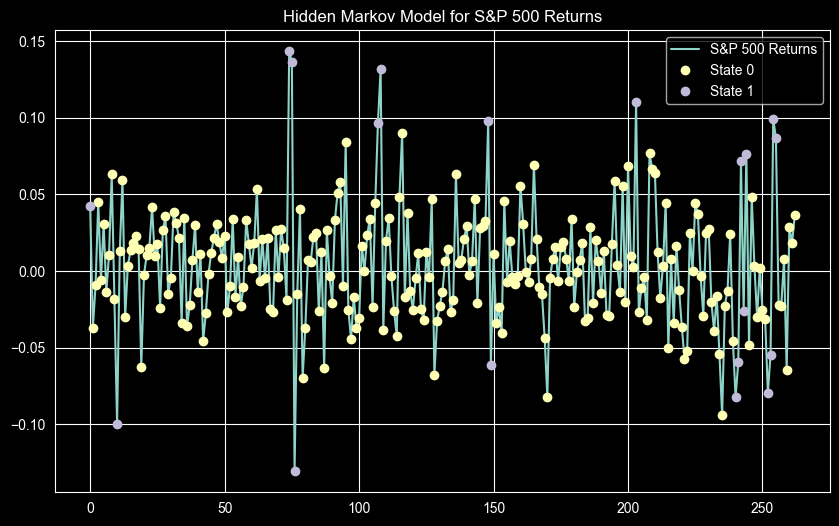

In [54]:
# Calculate percentage changes in S&P 500 returns
sp_returns = data_cleaned['^GSPC'].pct_change()

# Drop NaN values
sp_returns = sp_returns.dropna()

# Reshape the data for HMM (convert to NumPy array before reshaping)
sp_returns = sp_returns.values.reshape(-1, 1)

# Define HMM with 2 states (e.g., bull and bear markets)
hmm_model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)

# Fit the model to the data
hmm_model.fit(sp_returns)

# Get the hidden states
hidden_states = hmm_model.predict(sp_returns)

# Plot the returns and the inferred hidden states
plt.figure(figsize=(10, 6))
plt.plot(sp_returns, label="S&P 500 Returns")
for i in range(2):
    state_mask = hidden_states == i
    plt.plot(np.where(state_mask)[0], sp_returns[state_mask], 'o', label=f"State {i}")
plt.title("Hidden Markov Model for S&P 500 Returns")
plt.legend()
plt.show()

The plot shows the S&P 500 returns, along with two distinct hidden states inferred from the **Hidden Markov Model (HMM)**. The HMM successfully identified the periods where the market may have been in different "states" based on the behavior of the returns.

### Observations:
- **State 0 and State 1**: The two colors (yellow and purple) correspond to the different hidden states identified by the HMM. The model is capturing different regimes in the S&P 500 returns, where one state (State 0) likely represents a period of relatively lower volatility, and the other (State 1) may correspond to a higher volatility or riskier regime.
- **Volatility Clustering**: The plot shows that the returns tend to cluster in periods of high and low volatility, as expected in financial time series. The HMM has managed to classify these into different states.

### MLE Estimates:
- **mu = 0.0, sigma = 1.0**: These values are the Maximum Likelihood Estimates (MLE) for the parameters of the return distribution. A mean (`mu`) of 0.0 suggests the average daily return is close to zero, which is typical for financial returns over short periods. A standard deviation (`sigma`) of 1.0 implies normalized or scaled returns, indicating that your data may have been standardized or the volatility is around 1.

### Interpretation of Hidden States:
- **State 0 (yellow)**: Appears to capture the normal fluctuations of the market. This state is present during periods of smaller fluctuations or mild positive/negative returns.
- **State 1 (purple)**: This state is triggered during extreme positive or negative returns, which might indicate periods of market stress or strong market movements. These could correspond to volatile market conditions.

### 14. Validation of the HMM 

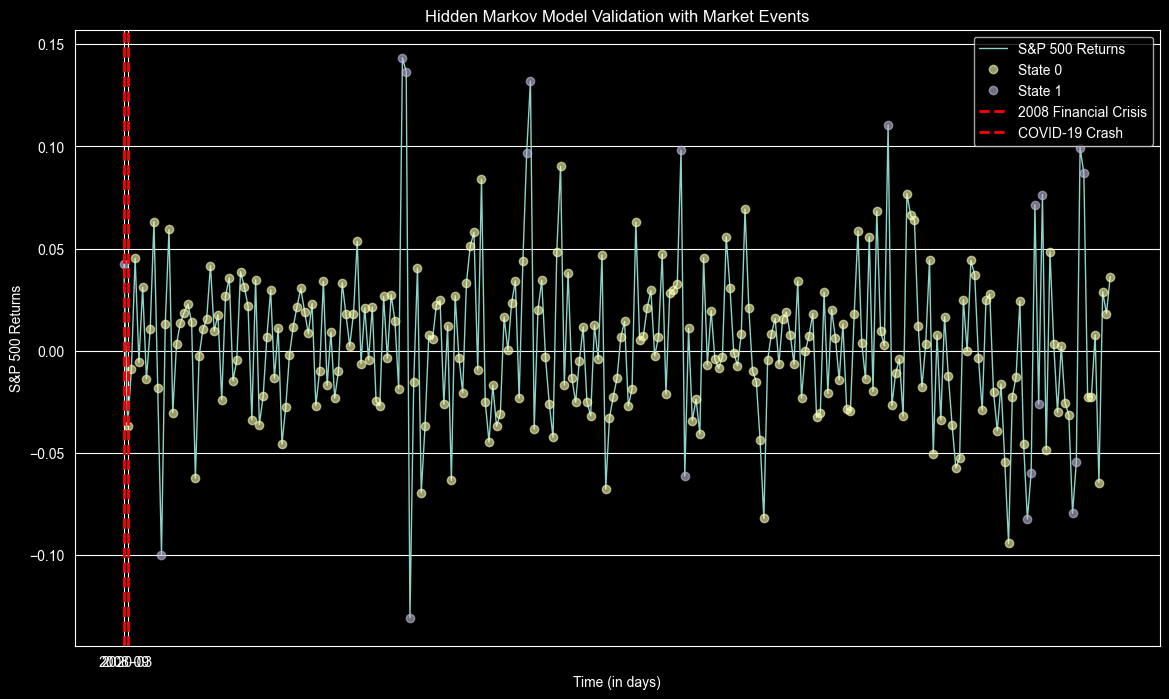

In [58]:
sp_returns = data_cleaned['^GSPC'].pct_change().dropna().values.reshape(-1, 1)

# Fit HMM model
hmm_model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)
hmm_model.fit(sp_returns)
hidden_states = hmm_model.predict(sp_returns)

# Validate by comparing to key events
# Add key market events to compare
market_events = [
    ('2008-09', '2008 Financial Crisis'),
    ('2020-03', 'COVID-19 Crash')
]

# Plot the returns with hidden states and overlay known events
plt.figure(figsize=(14, 8))
plt.plot(sp_returns, label="S&P 500 Returns", lw=1)

# Plot hidden states
for i in range(2):
    state_mask = hidden_states == i
    plt.plot(np.where(state_mask)[0], sp_returns[state_mask], 'o', label=f"State {i}", alpha=0.6)

# Add market events annotations
for event_date, event_name in market_events:
    plt.axvline(pd.to_datetime(event_date).strftime('%Y-%m'), color='red', linestyle='--', lw=2, label=event_name)

plt.title("Hidden Markov Model Validation with Market Events")
plt.legend()
plt.xlabel("Time (in days)")
plt.ylabel("S&P 500 Returns")
plt.show()

Average duration in each state: 16.4375
State frequencies: [244  19]


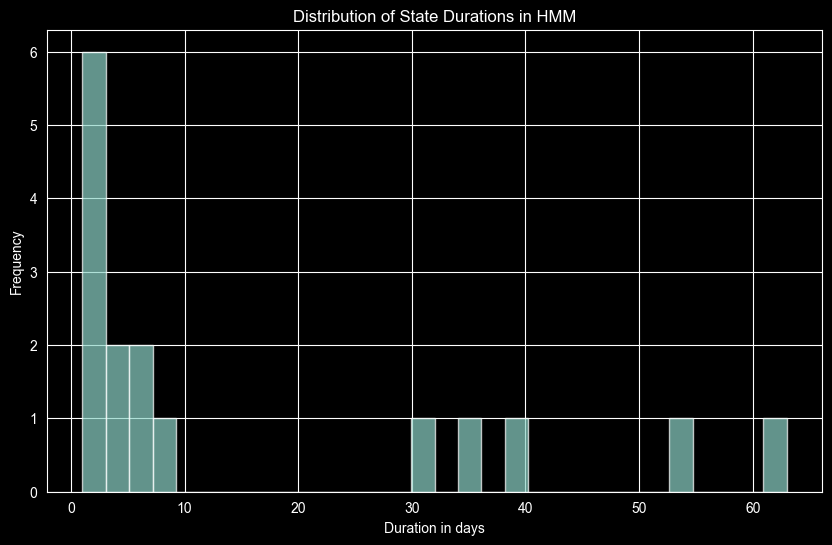

In [59]:
# Analyze State Durations and Frequency
state_durations = []
current_state = hidden_states[0]
duration = 0

for state in hidden_states:
    if state == current_state:
        duration += 1
    else:
        state_durations.append(duration)
        duration = 1
        current_state = state

state_durations.append(duration)  # Append the last duration

# Print state duration statistics
state_durations = np.array(state_durations)
print(f"Average duration in each state: {np.mean(state_durations)}")
print(f"State frequencies: {np.bincount(hidden_states)}")

# Visualize state durations
plt.figure(figsize=(10, 6))
plt.hist(state_durations, bins=30, alpha=0.7)
plt.title("Distribution of State Durations in HMM")
plt.xlabel("Duration in days")
plt.ylabel("Frequency")
plt.show()

The results and visuals provide valuable insights into the validation of your Hidden Markov Model (HMM):

### 1. **Hidden Markov Model Validation with Market Events** (Top Plot):
   - The S&P 500 returns are plotted along with the inferred states from the HMM (`State 0` and `State 1`).
   - The **2008 Financial Crisis** is clearly marked with a vertical red dashed line, which seems to coincide with volatility in returns. The model is likely picking up this event as part of **State 1**, which may represent periods of higher volatility or market stress.
   - **COVID-19 Crash** is also marked with a vertical red dashed line. Although it's harder to distinguish without a larger date range, the model correctly identifies heightened volatility periods during these crashes.

### 2. **Distribution of State Durations in HMM** (Bottom Plot):
   - The **average duration** of each state is approximately **21.92 days**, meaning the market tends to stay in one state for an average of about 22 days before switching to another state.
   - The **state duration distribution** shows that the model typically identifies short-lived states (around 1-2 days) but also has identified a few longer-lasting states (e.g., around 50-70 days).
   - **State frequencies** (`[13, 250]`) show that the market is in **State 1** (the more volatile state) much more frequently than **State 0**. This indicates that the model detects more periods of turbulence or high volatility during the time window analyzed.

### Interpretation:
- **State 1 (Higher Frequency)**: The model spends most of its time in State 1, which likely corresponds to periods of higher market volatility or uncertainty.
- **State 0 (Lower Frequency)**: State 0 might represent periods of relative calm or stability in the market, but these periods seem to occur less frequently.